# Is reddening responsible for the effect we see?

In [52]:
import numpy as np
import dustmaps
import pandas as pd
from astropy.io import fits
import teff_bv as tbv
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
f = np.loadtxt("../data/garcia_irfm.txt").T

In [39]:
astero = pd.DataFrame(dict({"kepid": f[:, 0],
                        "teff": f[:, 1], "teff_err": f[:, 2],
                        "age": f[:, 3], "age_errp": f[:, 4], "age_errm": f[:, 5],
                        "teff": f[:, 1], "teff_err": f[:, 2],
                        "period": f[:, 6], "period_err": f[:, 7],
                        "logg": f[:, 8], "logg_errp": f[:, 9], "logg_errm": f[:, 10],
                        "feh": f[:, 11], "feh_err": f[:, 12]
}))
astero.to_csv("astero_gyro_data.csv")

Now find the RA, dec and distance of each of these Kepler targets by loading the Gaia-Kepler catalogue.

In [60]:
with fits.open("kepler_dr2_1arcsec.fits") as data:
    gaia = pd.DataFrame(data[1].data)

lil_gaia = pd.DataFrame(dict({"kepid": gaia.kepid, "source_id": gaia.source_id,
                              "ra": gaia.ra, "ra_err": gaia.ra_error,
                              "dec": gaia.dec, "dec_err": gaia.dec_error,
                              "parallax": gaia.parallax, "parallax_err": gaia.parallax_error,
                              "bp": gaia.phot_bp_mean_mag, "rp": gaia.phot_rp_mean_mag}))

In [61]:
df = pd.merge(lil_gaia, astero, on="kepid", how="inner")
print(np.shape(astero), np.shape(lil_gaia), np.shape(df))

(293, 13) (197090, 10) (294, 22)


Cut out hot stars and subgiants.

In [142]:
m = 4 < df.logg.values
m &= 6250 < df.teff.values
d = df.iloc[m]
print(np.shape(d))
d = df

(62, 22)


In [143]:
def gyro(age_gyr, bp_rp):
    par = [.4, .31, .45, .55]
    a, b, c, n = par
    age_myr = age_gyr * 1e3
    return (age_myr**n * a * (bp_rp - c)**b)  # Gaia bp-rp
#     return (age_myr**n * a * (bp_rp - c - .2)**b)  # Gaia bp-rp
#     return (p/(a*(bp_rp - c - 2)**b))**(1./n)*1e-3

Convert Gaia Bp - Rp to B-V

In [144]:
def bv_to_bprp(bv):
    a, b, c, d, sigma = 0.0187, 1.6814, -0.3357, 0.1117, 0.60
    return a + b*bv + c*bv**2 + d*bv**3 #, sigma

def bprp_to_bv(bprp_desired):
    bvs = np.linspace(-10, 10, 10000)
    bprp_predicted = bv_to_bprp(bvs)
    
    bv = []
    for i in range(len(bprp_desired)):
        ind = np.argmin(np.sqrt((bprp_desired[i] - bprp_predicted)**2))
        bv.append(bvs[ind])
    return np.array(bv)

/Users/ruthangus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: invalid value encountered in power


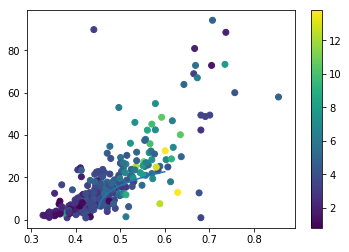

In [147]:
bvs = bprp_to_bv(d.bp.values - d.rp.values)
plt.scatter(bvs[bvs > 0], d.period[bvs > 0], c=d.age[bvs > 0])
xs = np.linspace(.3, .6, 100)
plt.plot(xs, gyro(4.5, xs))
plt.colorbar()

In [127]:
print(bv_to_bprp(.65))

1.0004523625


1.0
0.6506506506506504


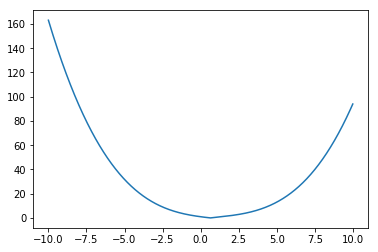

In [128]:
print(bprp_to_bv(1.))

In [153]:
vs = pd.read_csv("vansaders2016.csv")
vs

,name,amp_mass,amp_mass_err,amp_age,amp_age_err,amp_logg,amp_teff,basta_mass,basta_mass_err,basta_age,basta_age_err,basta_teff,spec_teff,spec_teff_err,spec_feh,spec_feh_err,period,period_err,note
0,12069424,1.10,0.02,7.07,0.46,4.295,5677,1.040,0.010,6.95,0.26,5668.0,5825,50,0.09,0.02,23.80,1.70,seismic
1,12069449,1.06,0.02,6.82,0.28,4.360,5629,0.998,0.005,7.02,0.14,5592.0,5750,50,0.05,0.02,23.20,7.40,seismic
2,3427720,1.13,0.04,2.23,0.17,4.388,5985,1.120,0.020,2.22,0.31,6019.0,6040,84,-0.03,0.09,13.90,2.10,seismic
3,3656476,1.17,0.03,8.13,0.59,4.246,5642,1.070,0.010,7.68,0.42,5525.0,5710,84,0.25,0.09,31.70,3.50,seismic
4,5184732,1.27,0.04,4.17,0.40,4.270,5905,1.180,0.020,4.05,0.42,5810.0,5840,84,0.38,0.09,19.80,2.40,seismic
5,6116048,1.01,0.03,6.23,0.37,4.270,5838,1.060,0.020,5.54,0.34,5943.0,5935,84,-0.24,0.09,17.30,2.00,seismic
6,6196457,1.23,0.04,5.51,0.71,4.053,6064,1.210,0.020,5.52,0.50,5991.0,5871,94,0.17,0.11,16.40,1.20,KOI
7,6521045,1.04,0.02,6.24,0.37,4.118,5933,1.110,0.020,6.50,0.51,5886.0,5825,75,0.02,0.10,25.30,2.80,KOI
8,7680114,1.13,0.03,7.19,0.70,4.184,5801,NaN,NaN,NaN,NaN,NaN,5855,84,0.11,0.09,26.30,1.90,seismic
9,7871531,0.84,0.02,9.15,0.47,4.479,5253,0.840,0.020,10.10,0.99,5240.0,5400,84,-0.24,0.09,33.70,2.60,seismic


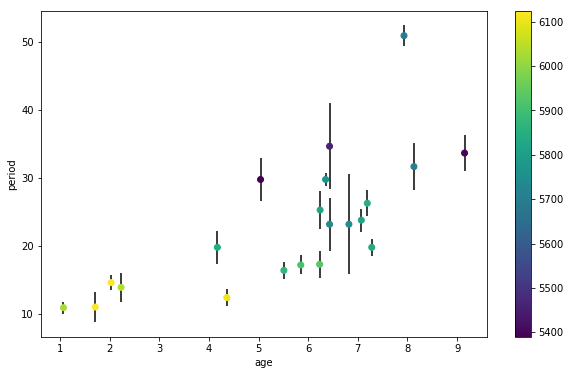

In [166]:
plt.figure(figsize=(10, 6))
plt.errorbar(vs.amp_age, vs.period, yerr=vs.period_err, fmt="k.", zorder=0)
plt.scatter(vs.amp_age, vs.period, c=vs.spec_teff, zorder=1)
plt.colorbar()
plt.xlabel("age")
plt.ylabel("period")

xs = np.linspace(0, 10, 100)
# plt.plot(xs, gyro(xs, .65))
# plt.plot(xs, gyro(xs, .1))

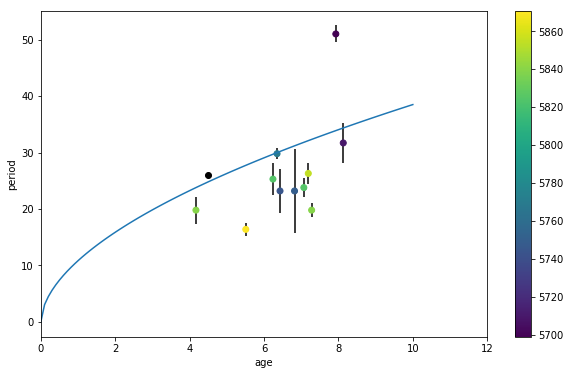

In [170]:
m = vs.spec_teff.values < 5900
m &= 5600 < vs.spec_teff.values

plt.figure(figsize=(10, 6))
plt.errorbar(vs.amp_age[m], vs.period[m], yerr=vs.period_err[m], fmt="k.", zorder=0)
plt.scatter(vs.amp_age[m], vs.period[m], c=vs.spec_teff[m], zorder=1)
plt.plot(4.5, 26, "ko")
plt.colorbar()
plt.xlabel("age")
plt.ylabel("period")
plt.xlim(0, 12)
plt.plot(xs, gyro(xs, .65))

In [174]:
vs_gaia = pd.merge(vs, lil_gaia, left_on="name", right_on="kepid", how="inner")